In [1]:
import pandas as pd
import time

from sklearn import preprocessing

from sklearn import metrics

from tqdm import tqdm

import apr_constants
import apr_functions_ul
import common_functions
import plot_functions

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Settings Path and Some Variables Value

K_MEANS_METRICS_PARAMETERS = ['Compared_Genre', 'With_Correlation', 'Inertia', 'Homo', 'Compl', 'V-Meas', 'Ari', 'Ami', 'Silhouette', 'Clusters', 'PCA_Components', 'Variance_Ratio']
k_means_metrics = pd.DataFrame(columns=K_MEANS_METRICS_PARAMETERS)

FEATURES_FILE_NAME = '20MFCC_100_10.csv'

DATA_PATH = '../notebooks/test_data/' + apr_constants.DATA
SAVE_ROOT = '../notebooks/test_data/' + apr_constants.ROOT_SAVE_PATH_NOTEBOOKS

common_functions.check_create_directory(SAVE_ROOT)

SAVING_FILE_NAME = 'K_MEANS_METRICS_'+FEATURES_FILE_NAME

FEATURES_FILE_PATH = DATA_PATH+FEATURES_FILE_NAME
IMAGE_FILE_NAME = FEATURES_FILE_NAME.replace('.csv', '')

CLUSTERS_NUM = 3

permutations_to_eval = pd.DataFrame(apr_functions_ul.get_permutation(apr_constants.GENRE_TARGET_NAMES, 3), columns=['Compared_Genre','With_Correlation'])

In [3]:
# Create CSV that contains some clustering metrics value and some other informations

for i, row in tqdm(permutations_to_eval.iterrows(), total=len(permutations_to_eval.index)):
  start_time = time.time()

  temp_k_means_metrics = pd.DataFrame(columns=K_MEANS_METRICS_PARAMETERS)
  With_Correlation = False

  original_file = pd.read_csv(FEATURES_FILE_PATH)
  df = original_file.copy()

  compared_genre = []

  new_genre = row.to_list()[0]
  corr_info = row.to_list()[1]

  compared_genre.append(new_genre[0] + '-' + new_genre[1] + '-' + new_genre[2])

  df = df[(df["genre"] == new_genre[0]) | (df["genre"] == new_genre[1]) | (df["genre"] == new_genre[2])]
  normalization = 'std'

  ord_enc = preprocessing.OrdinalEncoder()
  df['genre'] = ord_enc.fit_transform(df[['genre']])

  # Split df into x and Y
  target_col = 'genre'
  X = df.loc[:, df.columns != target_col]
  y = df.loc[:, target_col]

  x_cols = X.columns
  if normalization == 'std':
      # NORMALIZE X WITH STANDARD SCALER #
      resized_data = preprocessing.StandardScaler()
      np_scaled = resized_data.fit_transform(X)

  X = pd.DataFrame(np_scaled, columns=x_cols)
  y = pd.DataFrame(y).fillna(0).astype(int)

  if corr_info:
    # Get Correlation Matrix and Plot
    common_functions.get_correlated_features(X, 0.8, True, False, False, IMAGE_FILE_NAME)
    With_Correlation = True

    # Get PCA Variance Ratio
  num_components = apr_functions_ul.get_pca_var_ratio_plot(X, 0.8, False, False, IMAGE_FILE_NAME)

  # Get PCA Components and Variance Ratio
  pca_df, var_ratio = apr_functions_ul.get_pca(X, num_components)

  # Get K-means results
  labels, predict_clusters, centroids, k_means = apr_functions_ul.run_k_means(X, CLUSTERS_NUM, 42, save_model=False)

  temp_k_means_metrics['Compared_Genre'] = compared_genre
  temp_k_means_metrics['With_Correlation'] = With_Correlation
  temp_k_means_metrics['Inertia'] = k_means.inertia_
  temp_k_means_metrics['Homo'] = metrics.homogeneity_score(y.genre, predict_clusters)
  temp_k_means_metrics['Compl'] = metrics.completeness_score(y.genre, predict_clusters)
  temp_k_means_metrics['V-Meas'] = metrics.v_measure_score(y.genre, predict_clusters)
  temp_k_means_metrics['Ari'] = metrics.adjusted_rand_score(y.genre, predict_clusters)
  temp_k_means_metrics['Ami'] = metrics.adjusted_mutual_info_score(y.genre, predict_clusters)
  temp_k_means_metrics['Silhouette'] = metrics.silhouette_score(X, predict_clusters, metric='euclidean')
  temp_k_means_metrics['Clusters'] = CLUSTERS_NUM
  temp_k_means_metrics['PCA_Components'] = num_components
  temp_k_means_metrics['Variance_Ratio'] = var_ratio

  k_means_metrics = k_means_metrics.append(temp_k_means_metrics, ignore_index = True)

k_means_metrics.to_csv(SAVE_ROOT+SAVING_FILE_NAME, index=False)
executionTime = time.time() - start_time
print()
print('Save CSV!')
print('Execution Time: ', "{:.2f}".format(executionTime) + ' sec')

100%|██████████| 240/240 [00:18<00:00, 12.80it/s]


Save CSV!
Execution Time:  0.10 sec


In [4]:
#Plot First 5 Rows Of Tables

k_means_metrics.head()

,Compared_Genre,With_Correlation,Inertia,Homo,Compl,V-Meas,Ari,Ami,Silhouette,Clusters,PCA_Components,Variance_Ratio
0,blues-classical-country,False,587.662616,0.327095,0.384993,0.353690,0.214882,0.298112,0.219209,3,6,0.814717
1,blues-classical-country,True,587.662616,0.327095,0.384993,0.353690,0.214882,0.298112,0.219209,3,6,0.814717
2,blues-classical-disco,False,587.464025,0.481694,0.491801,0.486695,0.412269,0.448486,0.200430,3,7,0.838133
3,blues-classical-disco,True,587.464025,0.481694,0.491801,0.486695,0.412269,0.448486,0.200430,3,7,0.838133
4,blues-classical-hiphop,False,589.447592,0.409246,0.417833,0.413495,0.338141,0.369836,0.209482,3,6,0.804933


In [5]:
#Sort Silhouette Column Values For View The MAX

k_means_metrics.sort_values(['Silhouette'], ascending=False).head(n=1)

,Compared_Genre,With_Correlation,Inertia,Homo,Compl,V-Meas,Ari,Ami,Silhouette,Clusters,PCA_Components,Variance_Ratio
100,classical-hiphop-metal,False,465.613886,0.434732,0.531883,0.478426,0.350423,0.43227,0.361335,3,5,0.802915


In [6]:
#Assing Dataframe Value In Two Variables

test_best_sil_genre = k_means_metrics.sort_values(['Silhouette'], ascending=False, ignore_index=True).head(n=1)['Compared_Genre']
test_corr = k_means_metrics.sort_values(['Silhouette'], ascending=False).head(n=1)['With_Correlation']

In [7]:
#Plot Value

test_best_sil_genre = test_best_sil_genre.to_string()
test_best_sil_genre = test_best_sil_genre.replace(' ', '')[1:len(test_best_sil_genre)].split('-')
print('test_best_sil_genre: ', test_best_sil_genre)
print('test_corr: ', test_corr.bool())

test_best_sil_genre:  ['classical', 'hiphop', 'metal']
test_corr:  False


In [8]:
#Use The Previous Value For Make Some Test

test_df = original_file.copy()
test_compared_genre = []

test_new_genre = test_best_sil_genre
test_corr_info = test_corr.bool()

test_compared_genre.append(test_new_genre[0] + '-' + test_new_genre[1] + '-' + test_new_genre[2])
test_df = test_df[(test_df["genre"] == test_new_genre[0]) | (test_df["genre"] == test_new_genre[1]) | (test_df["genre"] == test_new_genre[2])]
normalization = 'std'

ord_enc = preprocessing.OrdinalEncoder()
test_df['genre'] = ord_enc.fit_transform(test_df[['genre']])

# Split df into x and Y
target_col = 'genre'
X_test = test_df.loc[:, test_df.columns != target_col]
y_test = test_df.loc[:, target_col]

x_test_cols = X_test.columns
if normalization == 'std':
    # NORMALIZE X_test WITH STANDARD SCALER #
    resized_data = preprocessing.StandardScaler()
    np_scaled = resized_data.fit_transform(X_test)

X_test = pd.DataFrame(np_scaled, columns=x_test_cols)
y_test = pd.DataFrame(y_test)

if test_corr_info:
  # Get Correlation Matrix and Plot
  print('Correlation Drop Features')
  common_functions.get_correlated_features(X_test, 0.8, True, False, False, IMAGE_FILE_NAME)

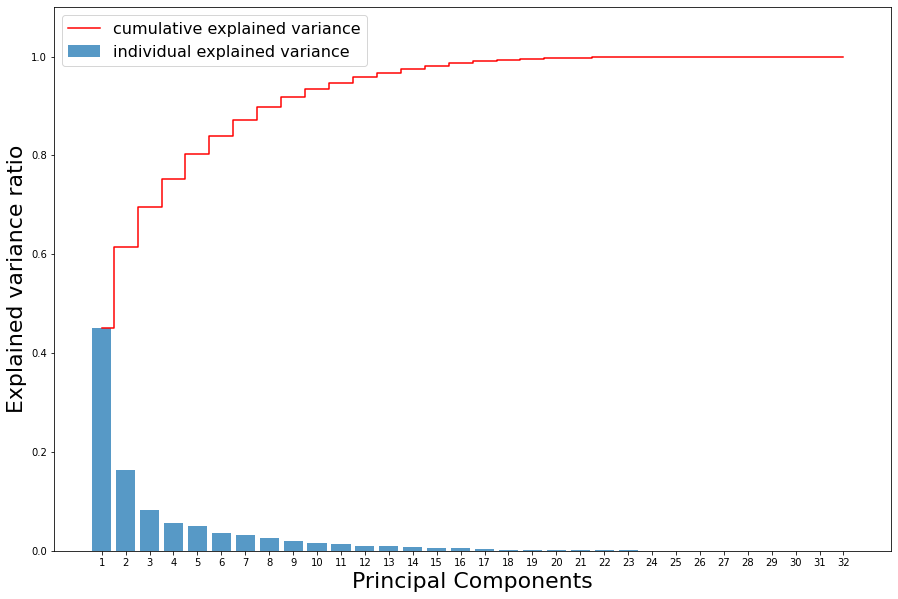

In [9]:
# Get PCA Variance Ratio

pca_components_to_use = apr_functions_ul.get_pca_var_ratio_plot(X_test, 0.8, False, IMAGE_FILE_NAME)

In [10]:
# Get PCA Components and Variance

pca_components, variance_ratio = apr_functions_ul.get_pca(X_test, pca_components_to_use)

In [11]:
# Get K-means results

labels_test, predict_clusters_test, centroids_test, k_means_test = apr_functions_ul.run_k_means(pca_components, CLUSTERS_NUM, 42, save_model=False)

In [12]:
# Merge PCA data with real label

pca_data_test = pd.concat([pca_components.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

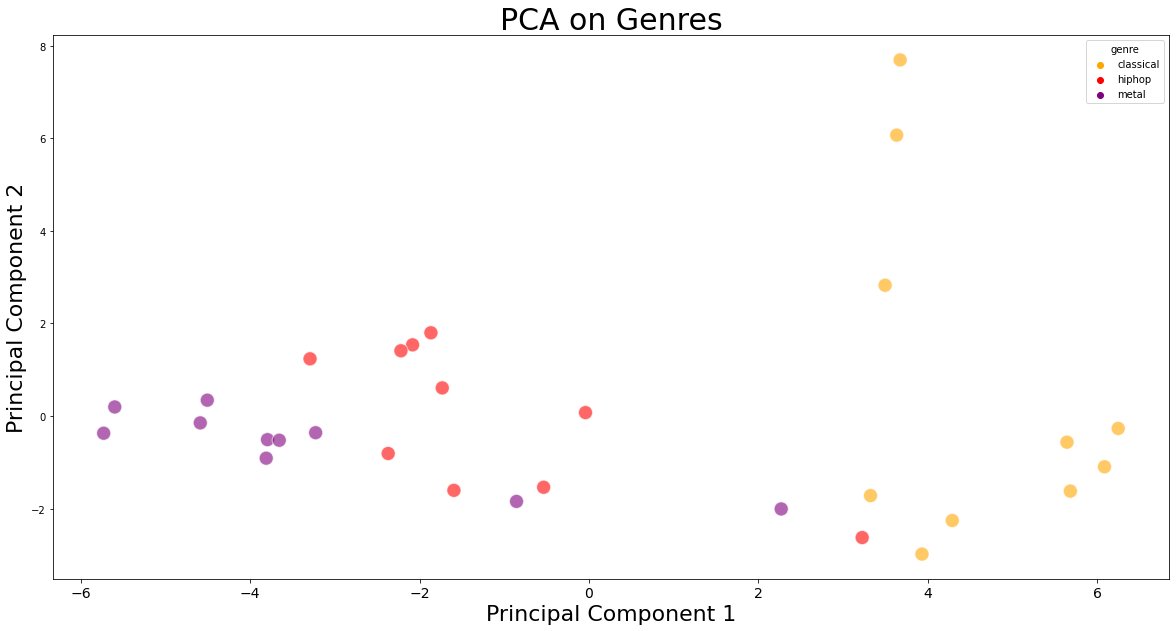

In [13]:
# Get PCA Plot For Two First Components

plot_functions.plot_pca(pca_data_test[['PC1','PC2','genre']], False, test_new_genre)

Save Clusters Plot


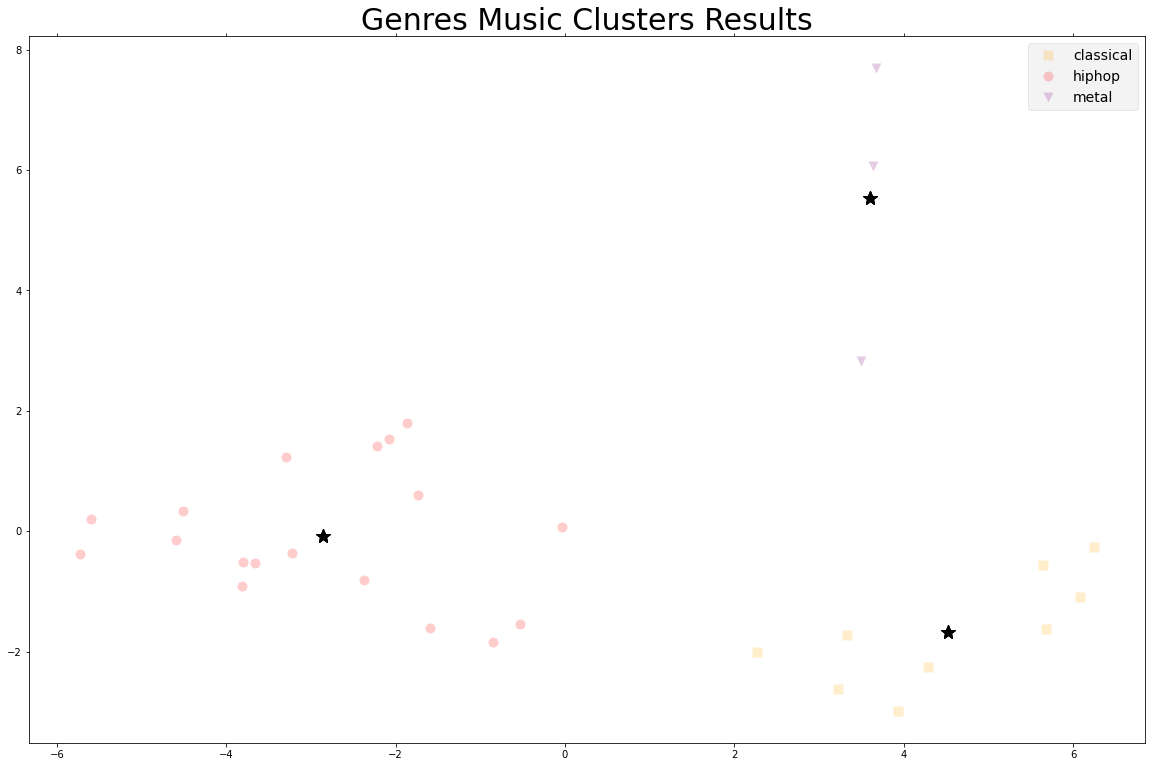

In [14]:
# Get Clusters Plot

plot_functions.plot_clusters(pca_data_test, centroids_test, labels_test, apr_constants.COLORS_LIST, test_new_genre, True, True, IMAGE_FILE_NAME, SAVE_ROOT)

Save K-means Confusion Matrix


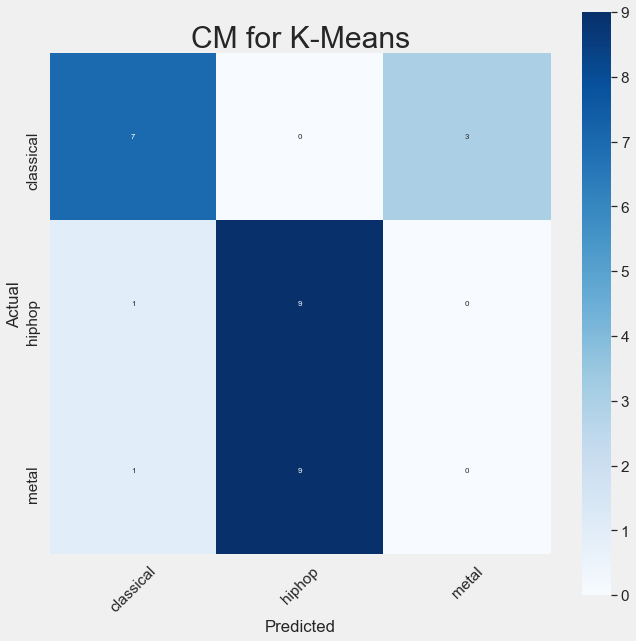

In [15]:
# Get K-means Confusion Matrix Plot

plot_functions.plot_confusion_matrix_k_means(pca_data_test, True, labels_test, test_new_genre, IMAGE_FILE_NAME, SAVE_ROOT)

Save Silhouette Plot


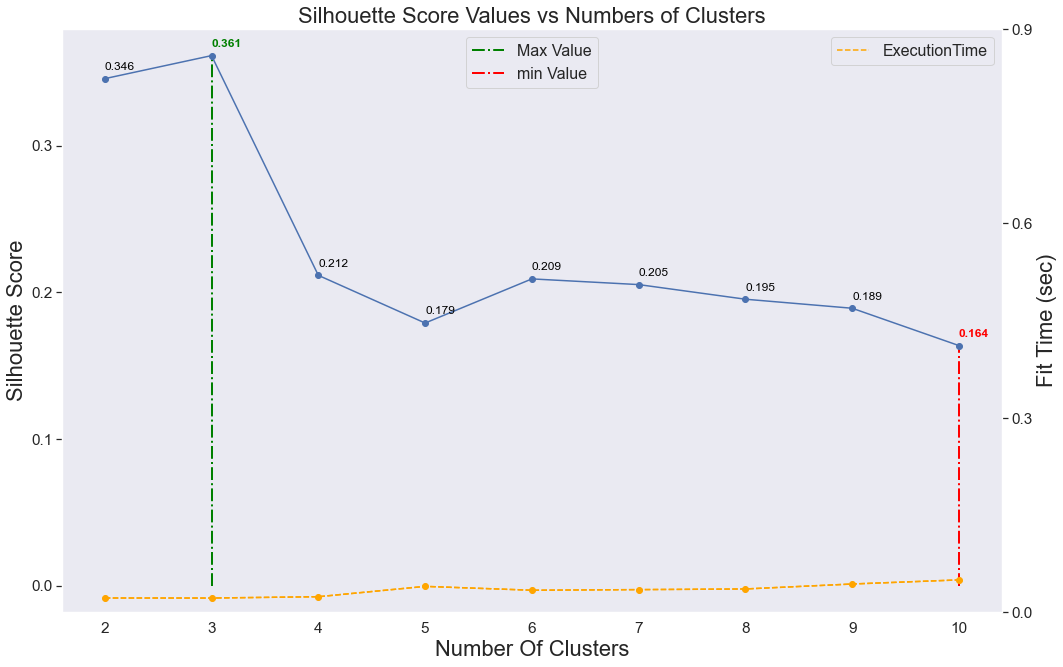

In [16]:
# Get Silhouette Plot

plot_functions.plot_silhouette(X_test, 2, 10, True, IMAGE_FILE_NAME, SAVE_ROOT)